# Viscous flow about a moving body
In this notebook we will demonstrate the simulation of a moving body. It is straightforward
to set up a moving body. The main caveat is that the simulation is slower,
because the integrator must update the operators continuously throughout the simulation.

We will demonstrate this on an oscillating flat plate.

In [1]:
using ViscousFlow

In [2]:
using Plots

### Problem specification and discretization
For simplicity, we will not create a free stream in this problem. Everything
here is the usual.

In [3]:
my_params = Dict()
my_params["Re"] = 200

200

In [4]:
xlim = (-1.0,1.0)
ylim = (-1.0,1.0)
my_params["grid Re"] = 4.0
g = setup_grid(xlim,ylim,my_params)

Δs = surface_point_spacing(g,my_params)

0.027999999999999997

### Set up body
Set up the plate and place it at the origin. (We don't actually have
to move it, since it defaults to the origin, but it's helpful to put
this here in case we wish to initialize it differently.)

In [5]:
body = Plate(1.0,Δs)
T = RigidTransform((0,0),0)
T(body)

Open polygon with 2 vertices and 36 points
   Current position: (0.0,0.0)
   Current angle (rad): 0.0


### Set the body motion
Now we specify the body motion. We will use oscillatory pitch-heave kinematics for this:

In [6]:
a = 0.25 # location of pitch axis, a = 0.5 is leading edge
ϕp = -π/2  # phase lag of pitch
ϕh = 0.0  # phase lag of heave
A = 0.25  # amplitude/chord
fstar = 1/π # fc/U
α₀ = 0 # mean angle of attack
Δα = 10π/180 # amplitude of pitching
U₀ = 0.0 # translational motion (set to zero in place of free stream)
K = π*fstar # reduced frequency, K = πfc/U

oscil1 = RigidBodyTools.PitchHeave(U₀,a,K,ϕp,α₀,Δα,A,ϕh)
motion = RigidBodyMotion(oscil1)

Rigid Body Motion:
  Oscillatory kinematics with
     Steady velocity U = (0.0,0.0)
     Ref angle α₀ = -1.5707963267948966
     Mean rotation rate α̇₀ = 0.0
     Pitch axis (rel. to centroid) a = (0.25,0.0)
     Frequency Ω = 1.0
     x amplitude Ax, phase lag ϕx = (0.0, 0.0)
     y amplitude Ay, phase lag ϕy = (0.25, 0.0)
     α amplitude Δα, phase lag ϕα = (0.0, 0.17453292519943295)


We can inspect the kinematics in this `motion` by plotting them:

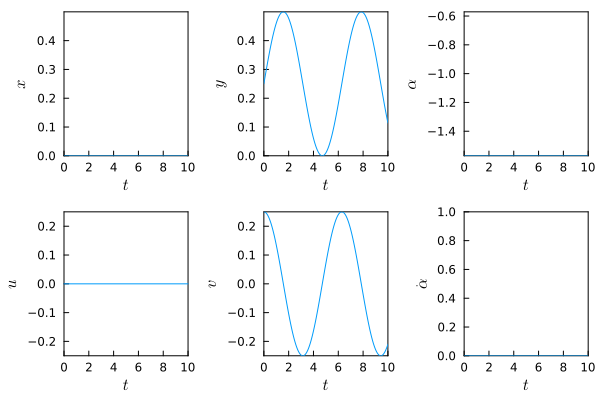

In [7]:
plot(motion)

### Define the boundary condition functions
Instead of using the default boundary condition functions, we define
special ones here that provide the instantaneous surface velocity (i.e. the velocity
of every surface point) from the prescribed
motion. Every surface has an "exterior" and "interior" side. For
a flat plate, these two sides are the upper and lower sides, and both sides
are next to the fluid, so both of them are assigned the prescribed velocity
of the plate. (For closed bodies, we would assign this velocity to only
one of the sides, and zero to the other side. We will see an example of this in a later case.)
We pack these into a special dictionary and
pass these to the system construction.

In [8]:
function my_vsplus(t,base_cache,phys_params,motions)
  vsplus = zeros_surface(base_cache)
  surface_velocity!(vsplus,base_cache,motions,t)
  return vsplus
end

function my_vsminus(t,base_cache,phys_params,motions)
  vsminus = zeros_surface(base_cache)
  surface_velocity!(vsminus,base_cache,motions,t)
  return vsminus
end

bcdict = Dict("exterior" => my_vsplus, "interior" => my_vsminus)

Dict{String, Function} with 2 entries:
  "interior" => my_vsminus
  "exterior" => my_vsplus

### Construct the system structure
Here, we supply the motion and boundary condition functions as additional arguments.

In [9]:
sys = viscousflow_system(g,body,phys_params=my_params,motions=motion,bc=bcdict);

Before we solve the problem, it is useful to note that the Reynolds number
we specified earlier may not be the most physically-meaningful Reynolds number.
More relevant in this problem is the Reynolds number based on the maximum
body speed.

In [10]:
Umax, imax, tmax, bmax = maxlistvelocity(sys)
Re_eff = my_params["Re"]*Umax

50.0

In [11]:
u0 = init_sol(sys)
tspan = (0.0,10.0)
integrator = init(u0,tspan,sys)

t: 0.0
u: (Dual nodes in a (nx = 102, ny = 108) cell grid of type Float64 data
  Number of Dual nodes: (nx = 102, ny = 108), [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0])

### Solve
This takes longer per time step than it does for stationary bodies. Here, we only
run it for 1.5 time units just to demonstrate it.

In [12]:
@time step!(integrator,1.5)

 18.283353 seconds (19.84 M allocations: 4.318 GiB, 3.46% gc time, 25.75% compilation time)


### Examine the solution
Let's look at a few snapshots of the vorticity field. Note that the
plotting here requires us to explicitly call the `surfaces`
function to generate the instantaneous configuration of the plate.

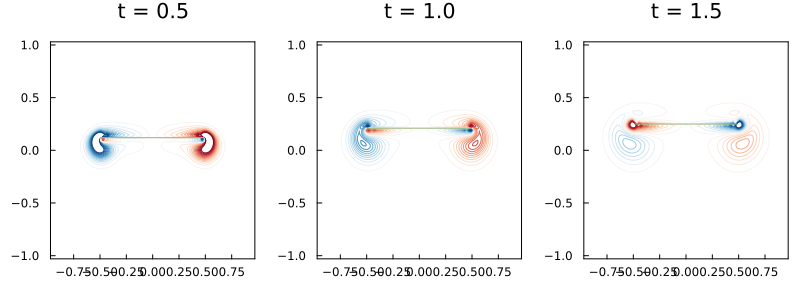

In [13]:
sol = integrator.sol
plt = plot(layout = (1,3), size = (800, 300), legend=:false)
tsnap = 0.5:0.5:1.5
for (i, t) in enumerate(tsnap)
    plot!(plt[i],vorticity(sol,sys,t),sys,layers=false,title="t = $(round(t,digits=2))",clim=(-5,5),levels=range(-5,5,length=30),color = :RdBu)
    plot!(plt[i],surfaces(sol,sys,t))
end
plt

and the forces

In [14]:
sol = integrator.sol
fx, fy = force(sol,sys,1);

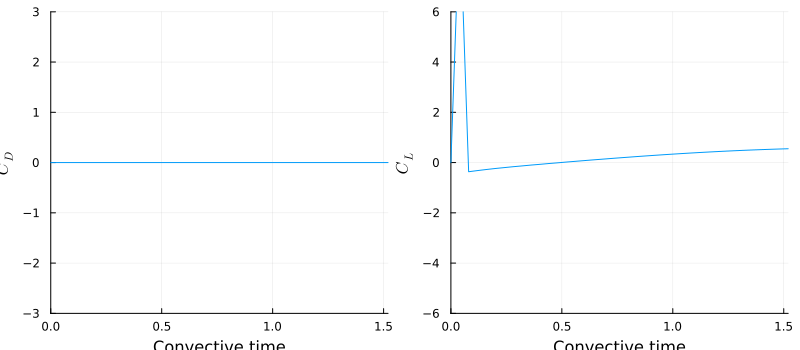

In [15]:
plot(
plot(sol.t,2*fx,xlim=(0,Inf),ylim=(-3,3),xlabel="Convective time",ylabel="\$C_D\$",legend=:false),
plot(sol.t,2*fy,xlim=(0,Inf),ylim=(-6,6),xlabel="Convective time",ylabel="\$C_L\$",legend=:false),
    size=(800,350)
)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*